In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from tqdm import tqdm
import math
import statistics
from scipy import stats

In [2]:
gdp = pd.read_csv("US_Nominal_GDP.csv")
debt = pd.read_csv("public_debt.csv")
gdp = gdp.rename(columns={'DATE': 'date', 'NGDPSAXDCUSQ': 'value'})

In [3]:
gdp = gdp.iloc[64:len(gdp)-5, :].reset_index().iloc[:, 1:]

In [4]:
X = np.array(gdp["value"])/1e6
Y = np.array(debt["value"])/1e6

In [5]:
def grad_a(x, y, a, b, c):
    return (y - a*x**2 - b*x - c)*(-2*x**2)
def grad_b(x, y, a, b, c):
    return (y - a*x**2 - b*x - c)*(-2*x)
def grad_c(x, y, a, b, c):
    return (y - a*x**2 - b*x - c)*(-2)
def swap_grad_a(x, y, a, b, c):
    return 2*(x + b/(2*a) - (b**2 +4*a*y - 4*a*c)**0.5/(2*a))*(-b/a**2 + (b**2 + 4*a*y - 4*a*c)**0.5 / (2*a**2) - (y-c)/(a*(b**2 + 4*a*y - 4*a*c)**0.5))
def swap_grad_b(x, y, a, b, c):
    return 2*(x + b/(2*a) - (b**2 +4*a*y - 4*a*c)**0.5/(2*a))*(1/(2*a) - b/(2*a*(b**2 + 4*a*y - 4*a*c)**0.5))
def swap_grad_c(x, y, a, b, c):
    return 2*(x + b/(2*a) - (b**2 +4*a*y - 4*a*c)**0.5/(2*a))*(2/(b**2 + 4*a*y - 4*a*c)**0.5)

In [6]:
def grad_lin_m(x, y, m, c):
    return (y - m*x - c)*(-2*x)
def grad_lin_c(x, y, m, c):
    return (y - m*x - c)*(-2)
def swap_grad_lin_m(x, y, m, c):
    return (x - y/m + c/m) * 2 * (y/m**2 - c/m**2)
def swap_grad_lin_c(x, y, m, c):
    return (x - y/m + c/m) * 2 * (1/m)

In [7]:
def Swap(X, Y, Z, a0 = None, b0 = None, c0 = None, epochs = 1e5, lr = 1e-7, error = 0.25, ers = 1e-2):
    a = a0
    b = b0
    c = c0
    if a == None:
        [a, b, c] = np.polyfit(X, Y, 2)
    L = []
    ep = []
    for e in tqdm(range(0, int(epochs))):
        gA = 0
        gB = 0
        gC = 0
        err = 0
        for i in range(0, len(Z)):
            if Z[i] == 1:
                gA += lr*grad_a(X[i], Y[i], a, b, c)
                gB += lr*grad_b(X[i], Y[i], a, b, c)
                gC += lr*grad_c(X[i], Y[i], a, b, c)
            if Z[i] == 0:
                try:
                    if b**2 + 4*a*Y[i] - 4*a*c < 0:
                        err += 1
                    else:
                        gA += lr*swap_grad_a(X[i], Y[i], a, b, c)
                        gB += lr*swap_grad_b(X[i], Y[i], a, b, c)
                        gC += lr*swap_grad_c(X[i], Y[i], a, b, c)
#                    print(gA, gB, gC)
                except:
                    err += 1
        gA /= (len(X) - err)
        gB /= (len(X) - err)
        gC /= (len(X) - err)
        ep.append(e + 1)
        L.append(gA**2 + gB**2 + gC**2)
        if err/len(Z) < error:
            a -= gA * lr
            b -= gB * lr
            c -= gC * lr
        else:
            a -= gA * lr
            b -= gB * lr
            c -= gC * lr
        if gA**2 + gB**2 + gC**2 < ers:
            plt.plot(ep, L)
            print(gA**2 + gB**2 + gC**2)
            return [a, b, c]
        if e == int(epochs) - 1:
            print(gA**2 + gB**2 + gC**2)
    print("Meh.")
    plt.plot(ep, L)
    return [a, b, c]

In [8]:
def SwapVar(X, Y, Z, s0, s1, a0 = None, b0 = None, c0 = None, epochs = 1e5, lr = 1e-7, error = 0.25, ers = 1e-2):
    a = a0
    b = b0
    c = c0
    if a == None:
        [a, b, c] = np.polyfit(X, Y, 2)
    L = []
    ep = []
    for e in tqdm(range(0, int(epochs))):
        gA = 0
        gB = 0
        gC = 0
        err = 0
        for i in range(0, len(Z)):
            if Z[i] == 1:
                gA += lr*grad_a(X[i], Y[i], a, b, c)/s1
                gB += lr*grad_b(X[i], Y[i], a, b, c)/s1
                gC += lr*grad_c(X[i], Y[i], a, b, c)/s1
            if Z[i] == 0:
                try:
                    if b**2 + 4*a*Y[i] - 4*a*c < 0:
                        err += 1
                    else:
                        gA += lr*swap_grad_a(X[i], Y[i], a, b, c)/s0
                        gB += lr*swap_grad_b(X[i], Y[i], a, b, c)/s0
                        gC += lr*swap_grad_c(X[i], Y[i], a, b, c)/s0
#                    print(gA, gB, gC)
                except:
                    err += 1
        gA /= (len(X))
        gB /= (len(X))
        gC /= (len(X))
        ep.append(e + 1)
        L.append(gA**2 + gB**2 + gC**2)
        if err/len(Z) < error:
            a -= gA * lr
            b -= gB * lr
            c -= gC * lr
        else:
            a -= gA * lr
            b -= gB * lr
            c -= gC * lr
        if gA**2 + gB**2 + gC**2 < ers:
           return [a, b, c]
    return [a, b, c]

In [9]:
def SwapLin(X, Y, Z, m0 = None, c0 = None, epochs = 1e5, lr = 1e-7, error = 0.25, ers = 1e-2):
    m = m0
    c = c0
    if m == None:
        [m, c] = np.polyfit(X, Y, 1)
    L = []
    ep = []
    for e in tqdm(range(0, int(epochs))):
        gM = 0
        gC = 0
        err = 0
        for i in range(0, len(Z)):
            if Z[i] == 1:
                gM += lr*grad_lin_m(X[i], Y[i], m, c)
                gC += lr*grad_lin_c(X[i], Y[i], m, c)
            if Z[i] == 0:
                gM += lr*swap_grad_lin_m(X[i], Y[i], m, c)
                gC += lr*swap_grad_lin_c(X[i], Y[i], m, c)
        gM /= len(X)
        gC /= len(X)
        ep.append(e + 1)
        L.append(gM**2 + gC**2)
        if err/len(Z) < error:
            m -= gM * lr
            c -= gC * lr
        else:
            m -= gM * lr
            c -= gC * lr
        if gM**2 + gC**2 < ers:
            plt.plot(ep, L)
            print(gM**2 + gC**2)
            return [m, c]
        if e == int(epochs) - 1:
            print(gM**2 + gC**2)
    print("Meh.")
    plt.plot(ep, L)
    return [m, c]

In [10]:
def SwapLinVar(X, Y, Z, s0, s1, m0 = None, c0 = None, epochs = 1e5, lr = 1e-7, error = 0.25, ers = 1e-2):
    m = m0
    c = c0
    if m == None:
        [m, c] = np.polyfit(X, Y, 1)
    L = []
    ep = []
    for e in tqdm(range(0, int(epochs))):
        gM = 0
        gC = 0
        err = 0
        for i in range(0, len(Z)):
            if Z[i] == 1:
                gM += lr*grad_lin_m(X[i], Y[i], m, c)/s1
                gC += lr*grad_lin_c(X[i], Y[i], m, c)/s1
            if Z[i] == 0:
                gM += lr*swap_grad_lin_m(X[i], Y[i], m, c)/s0
                gC += lr*swap_grad_lin_c(X[i], Y[i], m, c)/s0
        gM /= len(X)
        gC /= len(X)
        ep.append(e + 1)
        L.append(gM**2 + gC**2)
        if err/len(Z) < error:
            m -= gM * lr
            c -= gC * lr
        else:
            m -= gM * lr
            c -= gC * lr
        if gM**2 + gC**2 < ers:
            plt.plot(ep, L)
            print(gM**2 + gC**2)
            return [m, c]
        if e == int(epochs) - 1:
            print(gM**2 + gC**2)
    print("Meh.")
    plt.plot(ep, L)
    return [m, c]

In [11]:
def equality(A, B):
    for i in range(0, len(A)):
        if A[i] != B[i]:
            return False
    return True

In [12]:
def GMMSwap(X, Y, max_it = 1e6):
    # Initial Random Start
    n = len(X)
    Z = []
    Split = (min(X) + max(X))/2
    for i in range(0, n):
#        if X[i] < Split:
        if random.random() < 0.5:
            Z.append(0)
        else:
            Z.append(1)
    Z = np.array(Z)
    X1 = X[Z == 1]
    X0 = X[Z == 0]
    Y1 = Y[Z == 1]
    Y0 = Y[Z == 0]
    initial = Z
    pi0 = len(X0)/(len(X0) + len(X1))
    pi1 = 1 - pi0
    [a, b, c] = np.polyfit(X, Y, 2)
    e1 = Y1 - a*X1**2 - b*X1 - c
    e0 = X0 + b/(2*a) - (b**2 - 4*a*(c - Y0))**0.5 / (2*a)
    s1 = statistics.variance(e1)
    s0 = statistics.variance(e0)
    it = 0
    print("Here.")
    print([a, b, c])
    for t in tqdm(range(0, int(max_it))):
        print(t)
        Zn = []
        for i in range(0, n):
            v0 = pi0 * s0**(-0.5) * math.exp(-0.5/s0 * (X[i] + b/(2*a) - (b**2 - 4*a*(c - Y[i]))**0.5 / (2*a)))
            v1 = pi1 * s1**(-0.5) * math.exp(-0.5/s0 * (Y[i] - a*X[i]**2 - b*X[i] - c))
            if v0 > v1:
                Zn.append(0)
            else:
                Zn.append(1)
        Zn = np.array(Zn)
 #       if sum((Zn - Z)**2) == 0:
        if equality(Zn, Z):
            print("1")
            return [a, b, c], Z, initial, s0, s1
        [an, bn, cn] = SwapVar(X, Y, Zn, s0, s1, epochs = 4e4, lr = 1e-4, ers = 1e-30)
        if [an, bn, cn] == [a, b, c]:
            print("2")
            return [a, b, c], Z, initial, s0, s1
        Z = Zn
        a, b, c = an, bn, cn
        e1 = Y1 - a*X1**2 - b*X1 - c
        e0 = X0 + b/(2*a) - (b**2 - 4*a*(c - Y0))**0.5 / (2*a)
        s1 = statistics.variance(e1)
        s0 = statistics.variance(e0)
        it += 1
        print([a, b, c])
    print("Iters Reached")
    return [a, b, c], Z, initial, s0, s1

In [13]:
def GMMLinSwap(X, Y, max_it = 1e6):
    # Initial Random Start
    n = len(X)
    Z = []
    Split = (min(X) + max(X))/2
    for i in range(0, n):
#        if X[i] < Split:
        if random.random() < 0.5:
            Z.append(0)
        else:
            Z.append(1)
    Z = np.array(Z)
    X1 = X[Z == 1]
    X0 = X[Z == 0]
    Y1 = Y[Z == 1]
    Y0 = Y[Z == 0]
    initial = Z
    pi0 = len(X0)/(len(X0) + len(X1))
    pi1 = 1 - pi0
    [m, c] = np.polyfit(X, Y, 1)
    e1 = Y1 - m*X1 - c
    e0 = X0 - (Y0 - c)/m
    s1 = statistics.variance(e1)
    s0 = statistics.variance(e0)
    it = 0
    print("Here.")
    print([m, c])
    for t in tqdm(range(0, int(max_it))):
        print(t)
        Zn = []
        for i in range(0, n):
            v0 = pi0 * s0**(-0.5) * math.exp(-0.5/s0 * (X[i] - (Y[i] - c)/m))
            v1 = pi1 * s1**(-0.5) * math.exp(-0.5/s0 * (Y[i] - m*X[i] - c))
            if v0 > v1:
                Zn.append(0)
            else:
                Zn.append(1)
        Zn = np.array(Zn)
 #       if sum((Zn - Z)**2) == 0:
        if equality(Zn, Z):
            print("1")
            return [m, c], Z, initial, s0, s1
        [mn, cn] = SwapLinVar(X, Y, Zn, s0, s1, epochs = 4e4, lr = 1e-4, ers = 1e-30)
        if [mn, cn] == [m, c]:
            print("2")
            return [m, c], Z, initial, s0, s1
        Z = Zn
        m, c = mn, cn
        e1 = Y1 - m*X1 - c
        e0 = X0 - (Y0 - c)/m
        s1 = statistics.variance(e1)
        s0 = statistics.variance(e0)
        it += 1
        print([m, c])
    print("Iters Reached")
    return [m, c], Z, initial, s0, s1

In [14]:
S, Z, Z0, s0, s1 = GMMSwap(X, Y)

Here.
[0.6460656714354706, 0.8578272692490471, 0.11587014579886798]


  0%|                                               | 0/1000000 [00:00<?, ?it/s]

0



  0%|                                 | 1/1000000 [01:38<27270:55:09, 98.18s/it]

[0.645331434051994, 0.8581947241190888, 0.11630150357859666]
1



  0%|                                 | 2/1000000 [03:02<25302:21:25, 91.09s/it]

[0.6453359354453013, 0.8581953283583627, 0.11630141009211563]
2
1


Here.
[4.49724771804972, -2.840483200739337]


  0%|                                               | 0/1000000 [00:00<?, ?it/s]

0



  0%|                                  | 1/1000000 [00:29<8288:24:02, 29.84s/it]


8.403396307798531e-11
Meh.
[4.49728064380432, -2.8404993840819652]
1
1


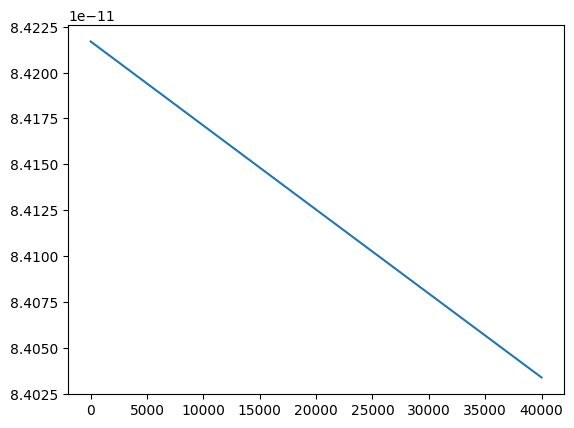

In [15]:
Sl, Zl, Z0l, s0l, s1l = GMMLinSwap(X, Y)

In [16]:
s0, s1

(0.0340997471222332, 1.5925178228853631)

In [17]:
s0l, s1l

(0.24951987510121698, 4.456140172175029)

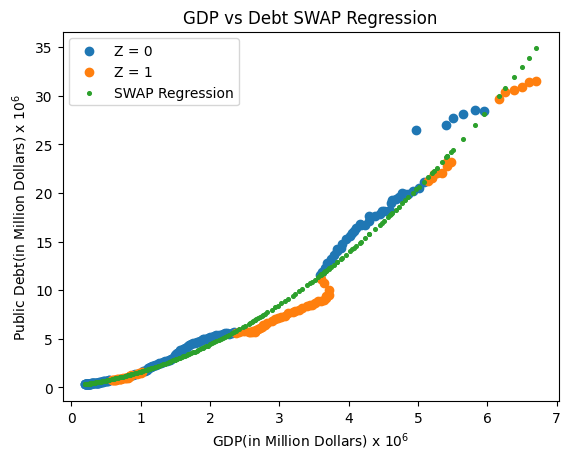

In [18]:
X1 = X[Z == 1]
X0 = X[Z == 0]
Y0 = Y[Z == 0]
Y1 = Y[Z == 1]
Y_Pred = S[0]*X**2 + S[1]*X + S[2]
plt.scatter(X0, Y0, label = "Z = 0")
plt.scatter(X1, Y1, label = "Z = 1")
plt.scatter(X, Y_Pred, label = "SWAP Regression", s= 7)
plt.title("GDP vs Debt SWAP Regression")
plt.xlabel(r"GDP(in Million Dollars) x $10^{6}$")
plt.ylabel(r"Public Debt(in Million Dollars) x $10^{6}$")
plt.legend()
plt.show()

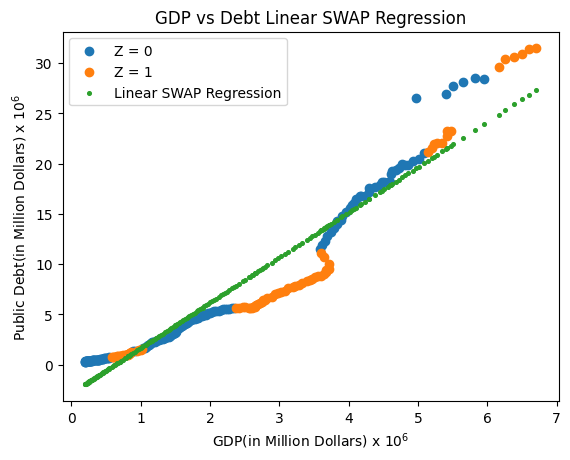

In [19]:
X1l = X[Z == 1]
X0l = X[Z == 0]
Y0l = Y[Z == 0]
Y1l = Y[Z == 1]
Y_Pred_Lin = Sl[0]*X + Sl[1]
plt.scatter(X0l, Y0l, label = "Z = 0")
plt.scatter(X1l, Y1l, label = "Z = 1")
plt.scatter(X, Y_Pred_Lin, label = "Linear SWAP Regression", s= 7)
plt.title("GDP vs Debt Linear SWAP Regression")
plt.xlabel(r"GDP(in Million Dollars) x $10^{6}$")
plt.ylabel(r"Public Debt(in Million Dollars) x $10^{6}$")
plt.legend()
plt.show()

In [20]:
a, b, c1 = np.polyfit(X, Y, 2)
m, c2 = np.polyfit(X, Y, 1)

In [36]:
Sl

[4.49728064380432, -2.8404993840819652]

In [37]:
S

[0.6453359354453013, 0.8581953283583627, 0.11630141009211563]

In [31]:
m, c2

(4.49724771804972, -2.840483200739337)

In [32]:
a, b, c1

(0.6460656714354706, 0.8578272692490471, 0.11587014579886798)

In [21]:
Y_Pred_Simple_Lin = m*X + c2
Y_Pred_Quad = a*X**2 + b*X + c1

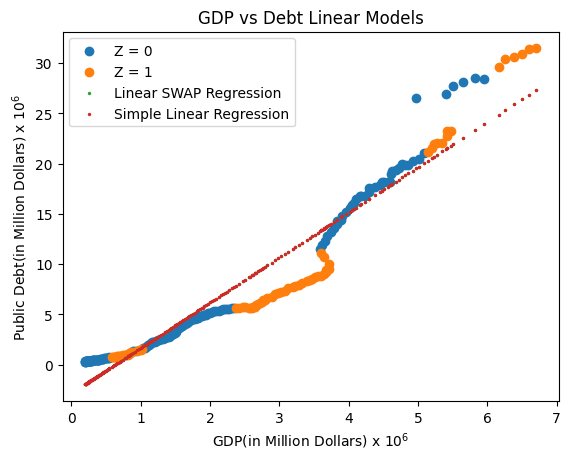

In [38]:
plt.title("Linear Models")
plt.scatter(X0l, Y0l, label = "Z = 0")
plt.scatter(X1l, Y1l, label = "Z = 1")
plt.scatter(X, Y_Pred_Lin, label = "Linear SWAP Regression", s= 2)
plt.scatter(X, Y_Pred_Simple_Lin, label = "Simple Linear Regression", s = 2)
plt.title("GDP vs Debt Linear Models")
plt.xlabel(r"GDP(in Million Dollars) x $10^{6}$")
plt.ylabel(r"Public Debt(in Million Dollars) x $10^{6}$")
plt.legend()
plt.show()

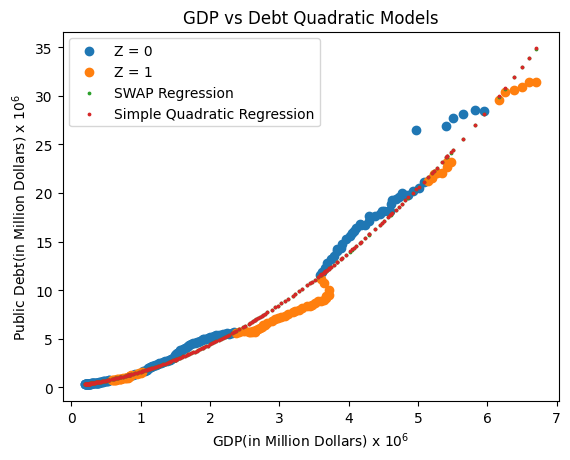

In [39]:
plt.title("Linear Models")
plt.scatter(X0, Y0, label = "Z = 0")
plt.scatter(X1, Y1, label = "Z = 1")
plt.scatter(X, Y_Pred, label = "SWAP Regression", s= 3)
plt.scatter(X, Y_Pred_Quad, label = "Simple Quadratic Regression", s = 3)
plt.title("GDP vs Debt Quadratic Models")
plt.xlabel(r"GDP(in Million Dollars) x $10^{6}$")
plt.ylabel(r"Public Debt(in Million Dollars) x $10^{6}$")
plt.legend()
plt.show()

In [24]:
len(X1)/len(X)

0.3406113537117904

In [25]:
len(X1l)/len(X)

0.3406113537117904

In [33]:
equality(X1, X1l)

True

In [26]:
S

[0.6453359354453013, 0.8581953283583627, 0.11630141009211563]

In [27]:
Sl

[4.49728064380432, -2.8404993840819652]

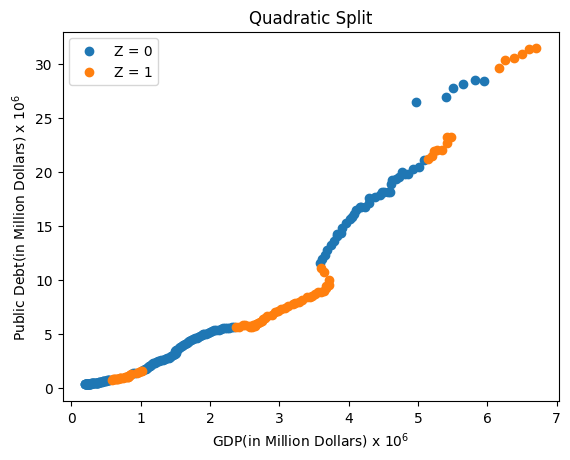

In [40]:
plt.scatter(X0, Y0, label = "Z = 0")
plt.scatter(X1, Y1, label = "Z = 1")
plt.legend()
plt.title("Quadratic Split")
plt.xlabel(r"GDP(in Million Dollars) x $10^{6}$")
plt.ylabel(r"Public Debt(in Million Dollars) x $10^{6}$")
plt.show()

In [ ]:
plt.scatter(X0l, Y0l, label = "Z = 0")
plt.scatter(X1l, Y1l, label = "Z = 1")
plt.title("Linear Split")
plt.xlabel(r"GDP(in Million Dollars) x $10^{6}$")
plt.ylabel(r"Public Debt(in Million Dollars) x $10^{6}$")
plt.legend()
plt.show()

In [30]:
equality(Z, Z0)

False